In [ ]:
# Import everything and load the pre-trained model
# NOTE: GuidedGradCAM does NOT WORK WITH ANY instances of ReLU that are
# inplace! Make sure to set them to false and that each ReLU instance is
# unique upon creation in the neural net

from torchvision.models import resnet18
from torchvision.datasets import MNIST
from torchvision import transforms
from torch import nn
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision

from google.colab import drive
drive.mount('/content/drive')
model = torch.load('drive/MyDrive/MNIST Feature Attribution/mnist-0123-only-noinplace')
model.eval()
model.zero_grad()

!pip install -q captum

from captum.attr import *
from captum.attr import visualization as viz
import numpy as np

!pip install -q umap-learn[plot]

import umap
import umap.plot

Mounted at /content/drive
     |████████████████████████████████| 1.4 MB 7.6 MB/s 
     |████████████████████████████████| 86 kB 2.9 MB/s 
     |████████████████████████████████| 1.1 MB 15.7 MB/s 
     |████████████████████████████████| 15.8 MB 22.8 MB/s 
     |████████████████████████████████| 76 kB 5.6 MB/s 
     |████████████████████████████████| 134 kB 71.2 MB/s 
     |████████████████████████████████| 837 kB 69.9 MB/s 
     |████████████████████████████████| 830 kB 65.7 MB/s 
     |████████████████████████████████| 822 kB 69.4 MB/s 
     |████████████████████████████████| 802 kB 50.6 MB/s 
     |████████████████████████████████| 802 kB 50.8 MB/s 
     |████████████████████████████████| 793 kB 61.5 MB/s 
     |████████████████████████████████| 793 kB 48.2 MB/s 
     |████████████████████████████████| 791 kB 63.0 MB/s 
     |████████████████████████████████| 786 kB 55.0 MB/s 
     |████████████████████████████████| 779 kB 80.3 MB/s 
     |████████████████████████████████| 778 kB 77.

In [ ]:
# GradCAM/GuidedGradCAM should be performed against the last convolutional layer
# in the network
gc = GuidedGradCam(model, model.layer4[1].conv2)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw



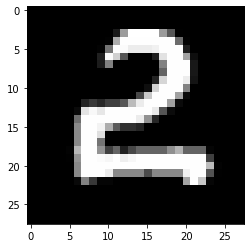

In [ ]:
# Get data and perform sanity check by showing piece of data
train_ds = MNIST("mnist", train=True, download=True, transform=transforms.ToTensor())
test_ds = MNIST("mnist", train=False, download=True, transform=transforms.ToTensor())

isolated_indexes = (test_ds.targets == 0) | (test_ds.targets == 1) | (test_ds.targets == 2) | (test_ds.targets == 3)
test_ds.targets = test_ds.targets[isolated_indexes]
test_ds.data = test_ds.data[isolated_indexes]

test_dl = DataLoader(test_ds, batch_size=500, shuffle=True, )
images, labels = iter(test_dl).next()
import matplotlib.pyplot as plt
image = images[0]
plt.imshow(image.squeeze(), cmap='gray')

In [ ]:
# perform attribution
attributions = gc.attribute(images, target=labels)

/usr/local/lib/python3.7/dist-packages/captum/_utils/gradient.py:59: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index
/usr/local/lib/python3.7/dist-packages/captum/attr/_core/guided_backprop_deconvnet.py:65: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  "Setting backward hooks on ReLU activations."


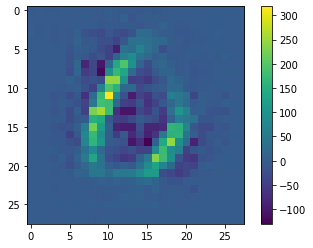

In [ ]:
# sanity check, make sure the attribution data is present
attribution = attributions[1]
plt.imshow(attribution.detach().squeeze()) 
plt.colorbar()

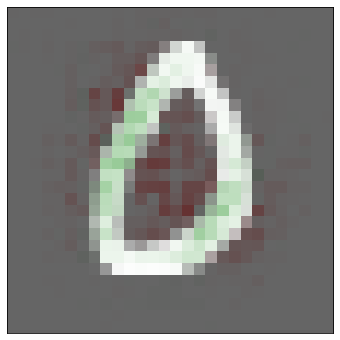

In [ ]:
# Overlay attribution on the original image with Captum
attribution = np.transpose(attributions[1].detach().numpy(), (1,2,0))
image = np.transpose(images[1].detach().numpy(), (1,2,0))

# plt.imshow()
_ = viz.visualize_image_attr(attribution, image, method="blended_heat_map", sign="all", alpha_overlay=0.4)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


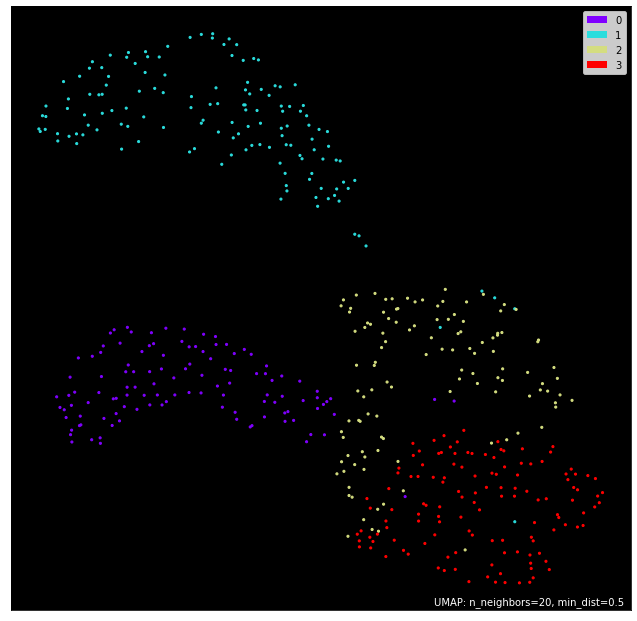

In [ ]:
# UMAP applied to feature attribution data

mapper = umap.UMAP(n_neighbors = 20,min_dist=0.5).fit(torch.reshape(attributions.detach().squeeze(), (500, 784)))

umap.plot.points(mapper, labels=labels, theme="fire")

In [ ]:
!pip install -q bokeh
from io import BytesIO
import base64
from PIL import Image

from bokeh import plotting, palettes
from bokeh.models import HoverTool, ColumnDataSource, CategoricalColorMapper
import numpy as np
import pandas as pd
import matplotlib

plotting.output_notebook()

In [ ]:
def embeddableImage(data):
    color_mapper = matplotlib.cm.get_cmap('viridis')
    data = color_mapper(data)
    img_data = (255 * data).astype(np.uint8)
    image = Image.fromarray(img_data, mode='RGBA')
    buffer = BytesIO()
    image.save(buffer, format='png')
    return 'data:image/png;base64,' + base64.b64encode(buffer.getvalue()).decode()

def umapPlot(embedding, x, y, yTrue=None, title=''):
    """ Plot the embedding of X and y with popovers using Bokeh """
    
    df = pd.DataFrame(embedding, columns=('x', 'y'))
    df['image'] = list(map(embeddableImage, x))
    df['digit'] = [str(d) for d in y]
    df['index'] = list(range(len(y)))
    if yTrue is not None:
        df['trueDigit'] = [str(d) for d in yTrue]

    datasource = ColumnDataSource(df)

    colorMapping = CategoricalColorMapper(factors=np.arange(10).astype(np.str), palette=palettes.Spectral10)

    plotFigure = plotting.figure(
        title=title,
        plot_width=600,
        plot_height=600,
        tools=('pan, wheel_zoom, reset')
    )

    if yTrue is None:
        tooltip = """
            <div>
                <div>
                    <img src='@image' style='float: left; width:100px; height:100px; image-rendering: pixelated; margin: 5px 5px 5px 5px'/>
                </div>
                <div>
                    <span style='font-size: 16px; color: #224499'>Digit:</span>
                    <span style='font-size: 18px'>@digit</span>
                    <span style='font-size: 16px; color: #224499'>Index:</span>
                    <span style='font-size: 18px'>@index</span>
                </div>
            </div>
            """
    else:
        tooltip = """
            <div>
                <div>
                    <img src='@image' style='float: left; margin: 5px 5px 5px 5px'/>
                </div>
                <div>
                    <span style='font-size: 16px; color: #224499'>Digit:</span>
                    <span style='font-size: 18px'>@digit (true: @trueDigit)</span>
                </div>
            </div>
            """
    plotFigure.add_tools(HoverTool(tooltips=tooltip))

    plotFigure.circle(
        'x', 'y',
        source=datasource,
        color=dict(field='digit', transform=colorMapping),
        line_alpha=0.6, fill_alpha=0.6, size=8
    )
    plotting.show(plotFigure)
    
    return plotFigure

In [ ]:
reducerMNIST = umap.UMAP(random_state=193, n_neighbors = 10,min_dist=0.5)
embeddingMNIST = reducerMNIST.fit_transform(torch.reshape(attributions.detach().squeeze(), (500, 784)))

In [ ]:
fig = umapPlot(embeddingMNIST, attributions.squeeze().detach().numpy(), labels.numpy(), title='UMAP projection of the MNIST Test dataset')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [ ]:
tmp_attributions = attributions.squeeze().detach().numpy()

In [ ]:
tmp_attribution = tmp_attributions[180]

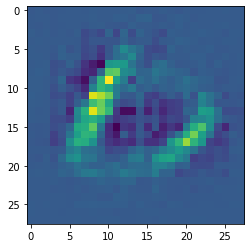

In [ ]:
plt.imshow(tmp_attribution)